## 画像のファイルパスを指定してobject detectionを実行する

Tensorflow Modelsのobject detection（v1.13.0）を利用してobject detectionを実行する

https://github.com/tensorflow/models/tree/master/research/object_detection

## このコードについて

このコードは object_detection_tutorial.ipynb を修正して画像パスに対して実行結果が表示されるようにしたものです。

https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

ライセンス

https://github.com/tensorflow/models/blob/master/LICENSE

### 条件

* モデルは生成済み
* 1枚の写真のパスを指定し、判定結果を表示する
* 詳細はブログ（TODO: URL追記）を参照

### Tensorflow Modelsのclone

Tensorflow Modelsをgithubからcloneしておきます。

In [1]:
# 生成したモデルのパス
PATH_TO_FROZEN_GRAPH = 'frozen_inference_graph.pb'

# ラベルファイルのパス
PATH_TO_LABELS = 'oid_v5_fruits_label_map.pbtxt'

In [2]:
%matplotlib inline

import sys
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

# cloneしたTensorflow Modelsのresearchディレクトリを指定
TF_MODELS_PATH = os.path.join(os.environ['HOME'], 'models', 'research')
sys.path.append(TF_MODELS_PATH)

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## グラフの読み込み

In [3]:
# グラフの読み込み
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## 画像のパスを引数に取って判定結果を返す関数

In [4]:
def detect(image_path, detection_graph):
    # 画像読み込んで形式を整える
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    image_np = np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)
    image = np.expand_dims(image_np, axis=0)

    # object detection
    with detection_graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]

    return image_np, output_dict

## Visualize関数

In [5]:
def visualize(image, output_dict, category_index):
    vis_util.visualize_boxes_and_labels_on_image_array(
        image,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

## object detectionの実行

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'Apple'},
 2: {'id': 2, 'name': 'Orange'},
 3: {'id': 3, 'name': 'Strawberry'},
 4: {'id': 4, 'name': 'Banana'}}

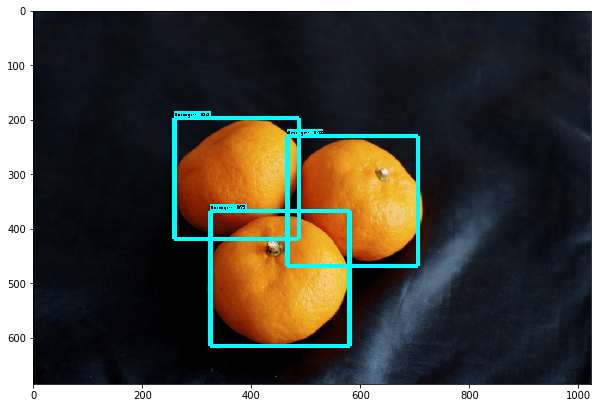

In [7]:
image, output_dict = detect('2a9603a9afd16362.jpg', detection_graph)
visualize(image, output_dict, category_index)

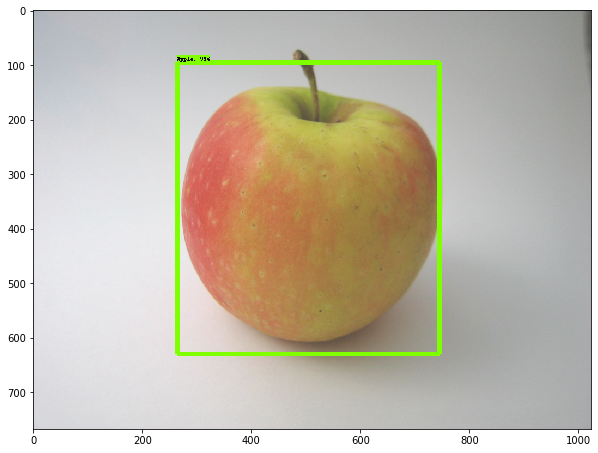

In [8]:
image, output_dict = detect('2cb9c8efddb5e42f.jpg', detection_graph)
visualize(image, output_dict, category_index)

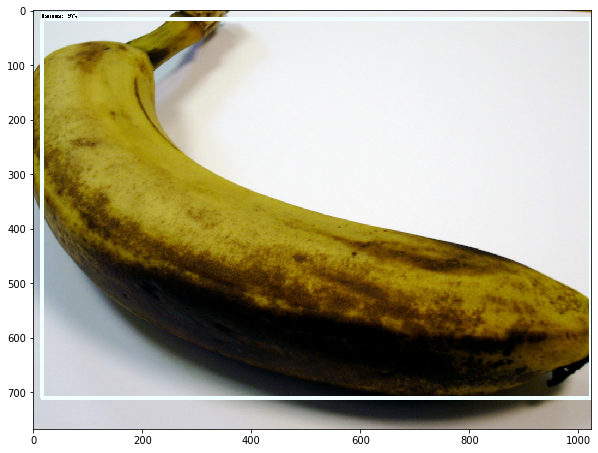

In [9]:
image, output_dict = detect('4ee0ff6dfabf8303.jpg', detection_graph)
visualize(image, output_dict, category_index)

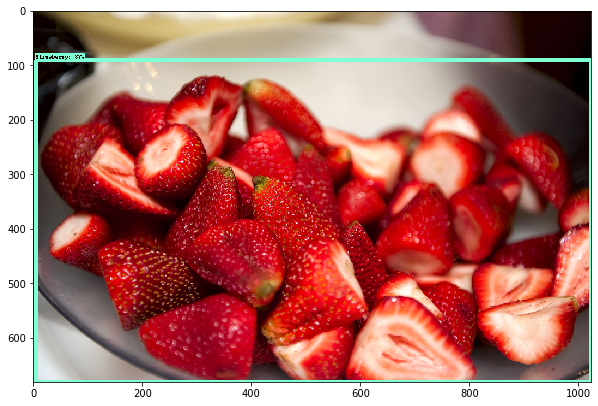

In [10]:
image, output_dict = detect('5e0a15749bc59cf5.jpg', detection_graph)
visualize(image, output_dict, category_index)